## Set Up Dependencies and Data


In [1]:
import joblib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
from teeplot import teeplot as tp


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/chaynes2019/AvidaGeneDupe/refs/heads/main/experiments/2022-3-29-PaperDuplication/TidiedData/FinalDominantGenomeLengths.csv")


## Reproducibility


In [3]:
%load_ext watermark
%watermark -iwbmuvg -iv


Last updated: 2025-08-10T18:01:05.554627+00:00

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.32.0

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.11.0-1018-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Git hash: 5e6417aa51ec041d5d7cc97dbe4be25bf6411af7

Git branch: main

numpy     : 2.2.2
teeplot   : 1.2.0
seaborn   : 0.13.2
joblib    : 1.3.2
matplotlib: 3.10.0
scipy     : 1.15.1
pandas    : 2.2.3

Watermark: 2.4.3



In [4]:
joblib.hash(df)


'feb88d22d682c00ebafcff9c650522c3'

# Describe data


In [5]:
df.head()


,Treatment,COPY_MUT_PROB,COPY_INS_PROB,COPY_DEL_PROB,DIVIDE_INS_PROB,DIVIDE_DEL_PROB,DIVIDE_SLIP_PROB,SLIP_FILL_MODE,Replicate #,Organism ID,Update Born,Task Count
0,Slip-NOP,0.0,0.0,0.0,0.0,0.0,0.05,1,1637,21818483,198469,100
1,Slip-NOP,0.0,0.0,0.0,0.0,0.0,0.05,1,1643,18603933,199567,117
2,Slip-NOP,0.0,0.0,0.0,0.0,0.0,0.05,1,1622,16254391,199669,149
3,Slip-NOP,0.0,0.0,0.0,0.0,0.0,0.05,1,1640,19401843,199586,113
4,Slip-NOP,0.0,0.0,0.0,0.0,0.0,0.05,1,1638,18787017,199627,100


In [6]:
df.describe()


,COPY_MUT_PROB,COPY_INS_PROB,COPY_DEL_PROB,DIVIDE_INS_PROB,DIVIDE_DEL_PROB,DIVIDE_SLIP_PROB,SLIP_FILL_MODE,Replicate #,Organism ID,Update Born,Task Count
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,2.100000e+02,210.000000,210.000000
mean,0.000714,0.001071,0.001071,0.014286,0.014286,0.035714,1.571429,1634.500000,1.999271e+07,199606.395238,185.752381
std,0.001132,0.002631,0.002631,0.022642,0.022642,0.022642,1.765470,60.765944,1.139001e+07,273.493282,164.911128
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1530.000000,4.010272e+06,197872.000000,100.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1582.250000,1.290504e+07,199468.000000,100.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,1.000000,1634.500000,1.860179e+07,199644.000000,103.000000
75%,0.002500,0.000000,0.000000,0.050000,0.050000,0.050000,3.000000,1686.750000,2.164564e+07,199781.000000,183.000000
max,0.002500,0.007500,0.007500,0.050000,0.050000,0.050000,5.000000,1739.000000,4.862347e+07,199978.000000,866.000000


In [7]:
df.nunique()


Treatment             7
COPY_MUT_PROB         2
COPY_INS_PROB         2
COPY_DEL_PROB         2
DIVIDE_INS_PROB       2
DIVIDE_DEL_PROB       2
DIVIDE_SLIP_PROB      2
SLIP_FILL_MODE        5
Replicate #         210
Organism ID         210
Update Born         184
Task Count           88
dtype: int64

In [8]:
df["Treatment"].unique()


array(['Slip-NOP', 'Baseline-Treatment', 'High-Mutation', 'Slip-random',
       'Slip-duplicate', 'Slip-scatter', 'Slip-scramble'], dtype=object)

In [9]:
df["Genome Length"] = df["Task Count"]


## Plot Data


In [10]:
signif = ""
env = "static"


In [11]:
def order(signif: str="") -> list:
    return [
        "Baseline",
        "High mutation rate",
        "Slip-scatter",
        "Slip-NOP",
        "Slip-random",
        f"Slip-scramble{signif}",
        f"Slip-duplicate{signif}",
    ]


teeplots/env=static+hue=treatment+inner=box+kind=violin+palette=set2-r+viz=catplot+x=treatment+y=genome-length+ext=.pdf
teeplots/env=static+hue=treatment+inner=box+kind=violin+palette=set2-r+viz=catplot+x=treatment+y=genome-length+ext=.png


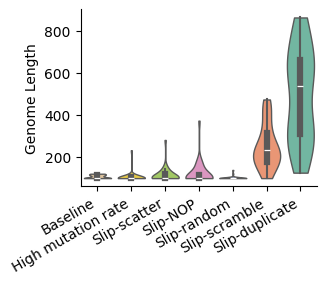

In [12]:
df_ = df.groupby(
    ["Treatment", "Replicate #"],
).max("Time").reset_index()
df_["Treatment"] = df_[
    "Treatment"
].replace(
    "Baseline-Treatment", "Baseline"
).replace(
    "High-Mutation", "High mutation rate"
).replace(
    "Slip-scramble", f"Slip-scramble{signif}"
).replace(
    "Slip-duplicate", f"Slip-duplicate{signif}",
)

with tp.teed(
    sns.catplot,
    data=df_,
    x="Treatment",
    y="Genome Length",
    hue="Treatment",
    order=order(signif),
    hue_order=order(signif),
    aspect=1.4,
    height=2.5,
    inner="box",
    kind="violin",
    linewidth=1,
    cut=0,
    palette="Set2_r",
    teeplot_outattrs={"env": env},
) as g:
    ax, = g.axes.flat
    ax.set_ylabel("Genome Length")
    ax.set_xlabel("")
    plt.xticks(rotation=30, ha="right")


## Slice and Dice


In [13]:
df_ = df.groupby(
    ["Treatment", "Replicate #"],
).max("Time").reset_index()
df_["Treatment"] = df_[
    "Treatment"
].replace(
    "Baseline-Treatment", "Baseline"
).replace(
    "High-Mutation", "High mutation rate"
).replace(
    "Slip-scramble", f"Slip-scramble{signif}"
).replace(
    "Slip-duplicate", f"Slip-duplicate{signif}",
)


In [14]:
def order2(signif):
    return [
        "Baseline",
        f"Slip-duplicate{signif}",
        "High mutation rate",
        "Slip-scatter",
        "Slip-NOP",
        "Slip-random",
        f"Slip-scramble{signif}",
    ]


/tmp/ipykernel_4063/3956078166.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="left")
/home/runner/.local/lib/python3.12/site-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/env=static+hue=treatment+inner=box+kind=violin+palette=set2-r+viz=catplot+x=treatment+y=genome-length+ext=.pdf, overwriting it
  warnings.warn(
/home/runner/.local/lib/python3.12/site-packages/teeplot/teeplot.py:322: UserWarning: teeplot already created file teeplots/env=static+hue=treatment+inner=box+kind=violin+palette=set2-r+viz=catplot+x=treatment+y=genome-length+ext=.png, overwriting it
  warnings.warn(


teeplots/env=static+hue=treatment+inner=box+kind=violin+palette=set2-r+viz=catplot+x=treatment+y=genome-length+ext=.pdf
teeplots/env=static+hue=treatment+inner=box+kind=violin+palette=set2-r+viz=catplot+x=treatment+y=genome-length+ext=.png


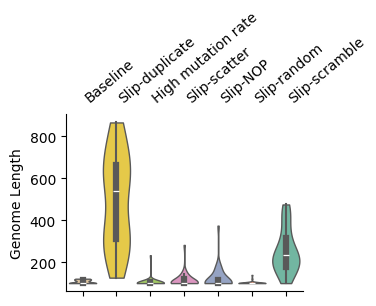

In [15]:
with tp.teed(
    sns.catplot,
    data=df_,
    x="Treatment",
    y="Genome Length",
    hue="Treatment",
    order=order2(signif),
    hue_order=order2(signif),
    aspect=1.4,
    height=2.5,
    cut=0,
    inner="box",
    kind="violin",
    linewidth=1,
    palette="Set2_r",
    teeplot_outattrs={"env": env},
) as g:
    ax, = g.axes.flat
    # Core lines for your request:
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_label_position("top")
    ax.tick_params(axis="x", labelbottom=False, labeltop=True)
    ax.set_ylabel("Genome Length")
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="left")


/tmp/ipykernel_4063/3593745385.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="left")
/tmp/ipykernel_4063/3593745385.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="left")


teeplots/col=split+env=static+hue=treatment+inner=box+kind=violin+palette=set2-r+viz=catplot+x=treatment+y=genome-length+ext=.pdf
teeplots/col=split+env=static+hue=treatment+inner=box+kind=violin+palette=set2-r+viz=catplot+x=treatment+y=genome-length+ext=.png


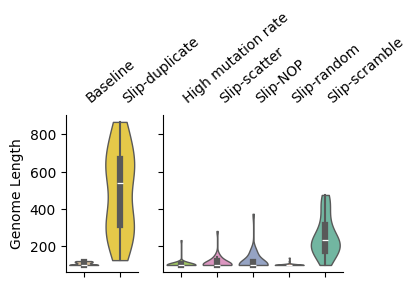

In [16]:
df_["split"] = df_["Treatment"].map(
    {
        "Baseline": 0,
        "High mutation rate": 1,
        f"Slip-duplicate{signif}": 0,
        f"Slip-scramble{signif}": 1,
        "Slip-NOP": 1,
        "Slip-random": 1,
        "Slip-scatter": 1,
    },
)

with tp.teed(
    sns.catplot,
    data=df_,
    x="Treatment",
    y="Genome Length",
    hue="Treatment",
    col="split",
    order=order2(signif),
    hue_order=order2(signif),
    aspect=0.8,
    height=2.5,
    inner="box",
    kind="violin",
    cut=0,
    sharex=False,
    linewidth=1,
    palette="Set2_r",
    teeplot_outattrs={"env": env},
) as g:
    g.set(ylabel="Genome Length")
    g.set_titles("")
    for ax in g.axes.flat:
        ax.xaxis.set_ticks_position("bottom")
        ax.xaxis.set_label_position("top")
        ax.tick_params(axis="x", labelbottom=False, labeltop=True)
        ax.set_xlabel("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="left")


    g.sharex = False
    g.axes.flat[0].set_xlim(None, 1.5)
    g.axes.flat[1].set_xlim(1.5, None)

    gs = g.axes[0, 0].get_gridspec()
    gs.set_width_ratios([2, 5])  # [left, right]

    g.fig.subplots_adjust(wspace=0.2)


## Statistical Tests


In [17]:
# --------------------------------------------------------------------
# Kruskal-Wallis across all treatment groups
# --------------------------------------------------------------------
grouped = df.groupby("Treatment")["Task Count"].apply(list)
kw_stat, kw_p = scipy_stats.kruskal(*grouped)

print(f"Kruskal-Wallis: H = {kw_stat:.3f}, p = {kw_p:.3e}")

# --------------------------------------------------------------------
# Pair-wise Mann-Whitney U tests
#    - Slip-scramble  vs Slip-NOP
#    - Slip-duplicate vs Slip-NOP
#    - Slip-duplicate vs Slip-scramble
#    Bonferroni-correct p-values for 3 comparisons
# --------------------------------------------------------------------
comparisons = [
    ("Slip-scramble",  "Slip-NOP"),
    ("Slip-duplicate", "Slip-NOP"),
    ("Slip-duplicate", "Slip-scramble")
]

results   = []
raw_ps    = []

for a, b in comparisons:
    x = df.loc[df["Treatment"] == a, "Genome Length"]
    y = df.loc[df["Treatment"] == b, "Genome Length"]

    u, p = scipy_stats.mannwhitneyu(x, y, alternative="two-sided")
    raw_ps.append(p)
    results.append((a, b, u, p))

# Bonferroni adjustment (alpha_nominal * number_of_tests)
bonf_ps = [min(p * len(comparisons), 1.0) for p in raw_ps]

# --------------------------------------------------------------------
# Report
# --------------------------------------------------------------------
for (a, b, u, p_raw), p_adj in zip(results, bonf_ps):
    print(f"Mann-Whitney {a} vs {b}: "
          f"U = {u:.0f}, raw p = {p_raw:.3e}, Bonferroni-corrected p = {p_adj:.3e}")


Kruskal-Wallis: H = 130.093, p = 1.229e-25
Mann-Whitney Slip-scramble vs Slip-NOP: U = 814, raw p = 3.784e-08, Bonferroni-corrected p = 1.135e-07
Mann-Whitney Slip-duplicate vs Slip-NOP: U = 877, raw p = 1.474e-10, Bonferroni-corrected p = 4.422e-10
Mann-Whitney Slip-duplicate vs Slip-scramble: U = 734, raw p = 2.770e-05, Bonferroni-corrected p = 8.309e-05


In [18]:
df.groupby("Treatment")["Genome Length"].agg(["mean", "std"]).round(2)


,mean,std
Treatment,,
Baseline-Treatment,107.80,8.90
High-Mutation,105.80,24.09
Slip-NOP,124.00,54.30
Slip-duplicate,491.33,222.96
Slip-random,102.00,7.88
Slip-scatter,116.53,35.48
Slip-scramble,252.80,105.11
